# STATS FOR FEATURE SELECTION and EDA


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import os
from datetime import datetime
from datetime import date

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from highlight_text import fig_text

In [16]:
edata = pd.read_csv("C:\\Users\\amaia\\Downloads\\lung_cancer_mortality_sample.csv")

In [17]:
edata[edata["survived"] ==0].sum()

id                                                                  206732788625
age                                                                      6970150
gender                         FemaleMaleFemaleFemaleFemaleFemaleMaleFemaleMa...
country                        LithuaniaSlovakiaLuxembourgPolandDenmarkBulgar...
diagnosis_date                 01/06/201818/03/202125/09/202220/10/201420/10/...
cancer_stage                   Stage IVStage IStage IVStage IStage IStage ISt...
beginning_of_treatment_date    08/06/201803/04/202126/09/202205/11/201405/11/...
family_history                 YesNoYesYesYesNoYesNoYesYesNoYesNoNoNoYesNoYes...
smoking_status                 Never SmokedPassive SmokerFormer SmokerFormer ...
bmi                                                                    3869523.4
cholesterol_level                                                       29629421
hypertension                                                               95171
asthma                      

In [18]:
edata.drop(["id"], axis = 1, inplace = True)
edata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162500 entries, 0 to 162499
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          162500 non-null  int64  
 1   gender                       162500 non-null  object 
 2   country                      162500 non-null  object 
 3   diagnosis_date               162500 non-null  object 
 4   cancer_stage                 162500 non-null  object 
 5   beginning_of_treatment_date  162500 non-null  object 
 6   family_history               162500 non-null  object 
 7   smoking_status               162500 non-null  object 
 8   bmi                          162500 non-null  float64
 9   cholesterol_level            162500 non-null  int64  
 10  hypertension                 162500 non-null  int64  
 11  asthma                       162500 non-null  int64  
 12  cirrhosis                    162500 non-null  int64  
 13 

## Categorical variables to investigate
- gender
- country
- cancer_stage
- family history
- smoking status
- hypertension
- asthma
- cirrhosis
- other cancer
- treatment type

## Continuous variables to investigate
- age
- cholesterol level
- bmi

# Mortality rate by country

is there a difference between motaliry of pacients between countries
(map of countries coloured by mortality rate to support this stat)


In [19]:
survived_false= edata[(edata["survived"] == 0)]
country_survial = survived_false.groupby(["country"]).size().reset_index(name="deaths")

#total count of patients by country
total_patients= edata.groupby(["country"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
country_survial["mortality_rate"] = country_survial["deaths"]/total_patients["total"] *100

#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
country_survial.drop(["deaths"], axis = 1, inplace = True)
country_survial["mortality_rate"].isna().sum()

0

## Running stats on if mortality is significantly different by country


In [20]:
from scipy.stats import chi2_contingency
contigency = pd.crosstab(country_survial["country"], country_survial["mortality_rate"])

chi2, p, dof, expected = chi2_contingency(contigency)
print(f"chi squared :{chi2}, p-value:{p}")
dof

chi squared :702.0000000000002, p-value:0.2368986680571129


676

#### No significant difference between mortality rate and country

## Plotting map with mortality by country

In [21]:
#renaming the countys column to match the geopandas file for when we merge
country_survial= country_survial.rename(columns={"country" : "Country"})


In [22]:
#For reading the geopanadas files
import geopandas as gpd

world = gpd.read_file("C:\\Users\\amaia\\Downloads\\ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
# filter on europe only
europe = world[world['CONTINENT'] == 'Europe']

In [23]:
#merging data on country
data = europe.merge(country_survial, how='left',
                    left_on='NAME', right_on='Country')

#droping countries in the geopandas which are not in our data 
data.dropna(subset=['mortality_rate'], inplace=True)
#rounding number and creating a percentage
data['mortality_rate'] = round(data['mortality_rate'], 1)
#data["Country"].unique()

AttributeError: module 'matplotlib.cm' has no attribute 'Yellows'

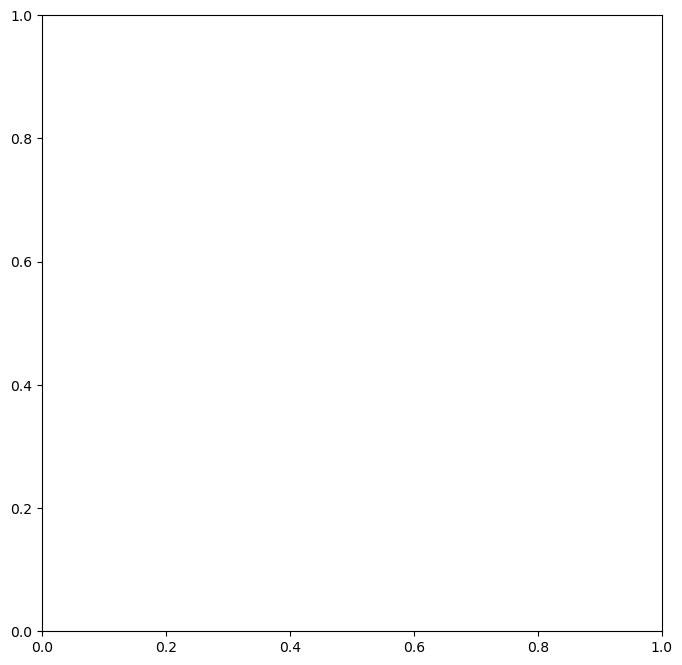

In [24]:
# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# define colors
cmap = cm.Yellows
min_rate, max_rate = 68.3, 84.6
norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

# create the plot
data.plot(column='mortality_rate', cmap=cmap, norm=norm, ax=ax,edgecolor='black', linewidth=0.3)

# custom axis - creates the graph axis but removes them from being displayed
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')


fig.text(0.1, 0.7, 'Mortality rate of \nlung cancer patients\nacross Europe',
         fontsize=20, fontweight='bold', fontfamily='serif')

# compute centroids for annotations
data_projected = data.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data['centroid'] = data_projected['centroid'].to_crs(data.crs)
countries_to_annotate = ['France', 'Sweden', 'Poland', 'Austria', 'Hungary', 'Romania', 'Latvia', 'Estonia', 'Germany', 'Bulgaria', 'Greece',
       'Spain', 'Ireland', 'Italy','Finland']

#these are the positions of the text on the countries
adjustments = {
    'France': (9, 3),
    'Italy': (-2.4, 2),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2.5),
    'Romania': (0, -0.5),
    'Bulgaria': (0, -0.6),
    'Greece': (-1.2, -0.8),
    'Croatia': (1, -1),
    'Cyprus': (0, -1),
    'Ireland': (0, -1),
    'Malta': (0, -1),
    'Slovenia': (0, -1),
    'Slovakia': (-0.7, -0.8),
    'Estonia': (0, -0.7),
    'Latvia': (1, -0.5),
    'Belgium': (0, -0.7),
    'Austria': (0, -1),
    'Spain': (0, -1),
    'Portugal': (-4, -1),
    'Luxembourg': (0, -1),
    'Germany': (-0.2, 0),
    'Hungary': (-0.3, -1),
    'Czechia': (0, -1),
    'Poland': (0, -1),
    'Sweden': (-1.5, -1),
    'Denmark': (0, -1),
    'Netherlands': (0, 0),
    'Switzerland': (0, -0.5),
}
# annotate countries
for country in countries_to_annotate:

    # get centroid
    centroid = data.loc[data['NAME'] == country, 'centroid'].values[0]
    x, y = centroid.coords[0]

    # get corrections
    x += adjustments[country][0]
    y += adjustments[country][1]

    # get rate and annotate
    rate = data.loc[data['NAME'] == country, 'mortality_rate'].values[0]
    ax.annotate(f'{country[:3]} {rate}%', (x, y), textcoords="offset points", xytext=(5, 5),
                ha='center', fontsize=9, fontfamily='DejaVu Sans', color='black', fontweight = "bold")

# display the plot
plt.tight_layout()
#plt.show()
plt.savefig('mortality regions.png', transparent=True, dpi=300)

### As the chi-squared suggested the mortality rate across the countries is quite uniform with only a few % difference between them

### Mortality rate by age

In [ ]:
## define age groups to create age categories
age_bins = [0,10, 15,20,25,30,35, 40,45,50,55, 60,65,70,75, 80,85,90,95,100]

# Create categorical variable for age groups
edata['age_group'] = pd.cut(edata['age'], bins=age_bins)


In [ ]:
survived_false= edata[(edata["survived"] == 0)]
age_survial = survived_false.groupby(["age", "gender"]).size().reset_index(name="deaths")

#total count of patients by country
total_patients= edata.groupby(["age", "gender"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
age_survial["mortality_rate"] = age_survial["deaths"]/total_patients["total"] *100

#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
#age_survial.drop(["deaths"], axis = 1, inplace = True)
sns.lineplot(age_survial, x = "age", y = "mortality_rate", hue = "gender")

In [ ]:
survived_false= edata[(edata["survived"] == 0)]
chol_survial = survived_false.groupby(["cholesterol_level", "gender"]).size().reset_index(name="deaths")

#total count of patients by country
total_patients= edata.groupby(["cholesterol_level", "gender"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
chol_survial["mortality_rate"] = chol_survial["deaths"]/total_patients["total"] *100
chol_survial[(chol_survial["gender"] == "Male")].quantile()  #82.915718
#chol_survial[(chol_survial["gender"] == "Female")].max() #82.142857
#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
#age_survial.drop(["deaths"], axis = 1, inplace = True)
#plt.figure(figsize = (14,6))
#sns.lineplot(chol_survial, x = "cholesterol_level", y = "mortality_rate", hue= "gender")
#plt.axvline(200,c= 'black', alpha = 0.3)
#plt.axhline(y =  , color = 'r') 

In [ ]:
survived_false= edata[(edata["survived"] == 0)]
bmi_survial = survived_false.groupby(["bmi", "gender"]).size().reset_index(name="deaths")

#total count of patients by country
total_patients= edata.groupby(["bmi", "gender"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
bmi_survial["mortality_rate"] = bmi_survial["deaths"]/total_patients["total"] *100

#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
#age_survial.drop(["deaths"], axis = 1, inplace = True)
sns.lineplot(bmi_survial, x = "bmi", y = "mortality_rate")

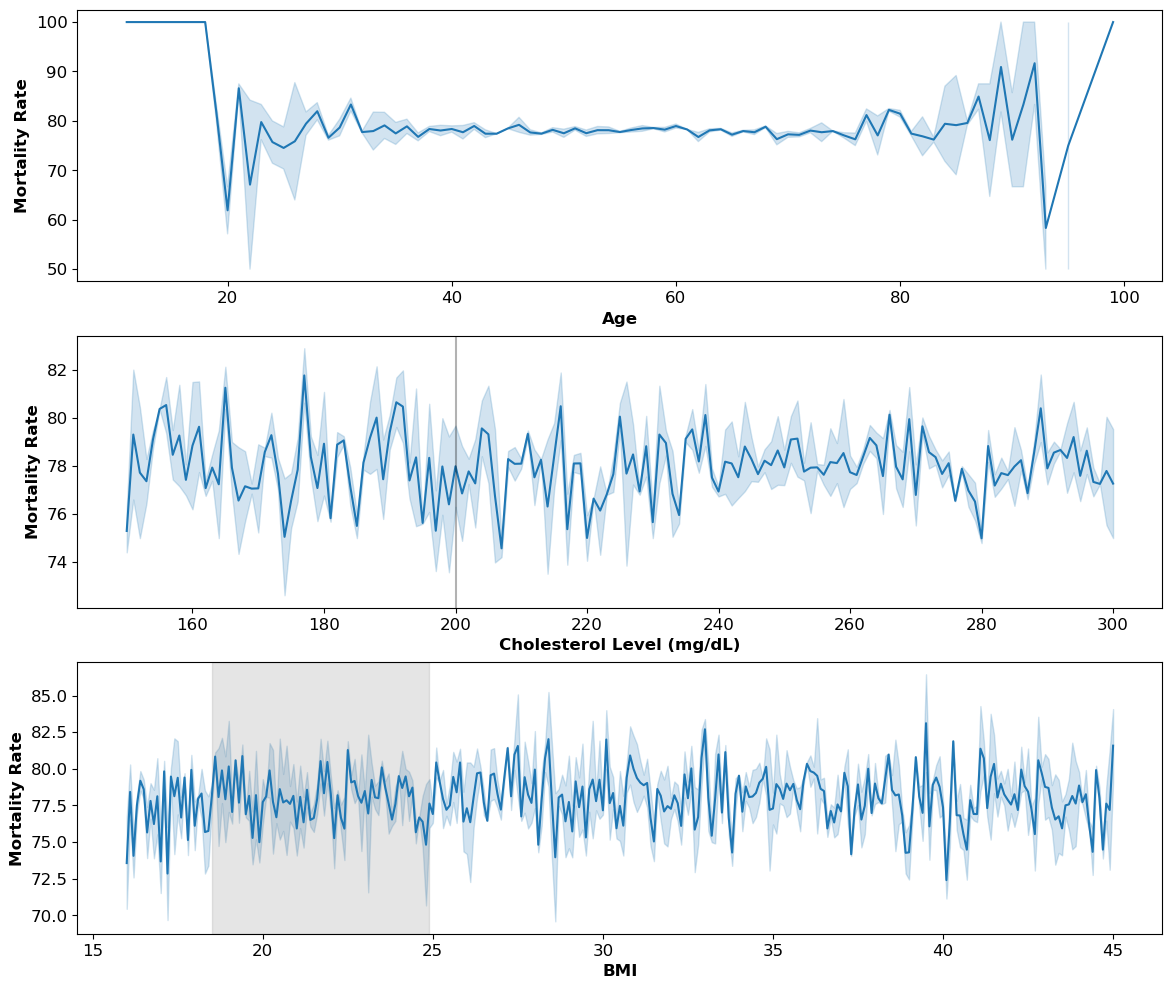

In [26]:
fig, axes = plt.subplots(ncols=1, nrows = 3, figsize=(14, 12))
sns.lineplot(age_survial, x = "age", y = "mortality_rate", ax= axes[0])
axes[0].set_xlabel('Age', weight = "bold", size = 12)
axes[0].set_ylabel('Mortality Rate', weight = "bold", size = 12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

sns.lineplot(chol_survial, x = "cholesterol_level", y = "mortality_rate", ax= axes[1])
axes[1].set_xlabel('Cholesterol Level (mg/dL)', weight = "bold", size = 12)
axes[1].set_ylabel('Mortality Rate', weight = "bold", size = 12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].axvline(200,c= 'black', alpha = 0.3)
#axes[1].axhline(y = 50, color = 'r') 




sns.lineplot(bmi_survial, x = "bmi", y = "mortality_rate", ax= axes[2])
axes[2].set_xlabel('BMI', weight = "bold", size = 12)
axes[2].set_ylabel('Mortality Rate', weight = "bold", size = 12)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].axvspan(18.5, 24.9, alpha = 0.2, color='gray')
#plt.tight_layout()
#plt.savefig('data continous distributions.png', transparent=True, dpi=300)

In [ ]:

sns.lineplot(chol_survial, x = "cholesterol_level", y = "mortality_rate",hue = "gender")
plt.xlabel('Cholesterol Level (mg/dL)', weight = "bold", size = 12)
plt.ylabel('Mortality Rate', weight = "bold", size = 12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].axvline(200,c= 'black', alpha = 0.3)


In [ ]:
survived_false= edata[(edata["survived"] == 1)]
age_survial_live = survived_false.groupby(["age_group"]).size().reset_index(name="survived")

#total count of patients by country
total_patients= edata.groupby(["age_group"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
age_survial_live["survival_rate"] = age_survial_live["survived"]/total_patients["total"] *100

#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
#age_survial_live.drop(["survived"], axis = 1, inplace = True)
age_survial_live

In [ ]:
edata['age_midpoint'] = edata['age_group'].apply(lambda x: x.mid)